# Adult Income Classification Analysis

This application evaluates various machine learning techniques, such as Random Forest, Logistic Regression, and Multi-Layer Perceptron in analysis regarding feature importance and relations in the adult income classification dataset. Our analysis concludes that certain fields, such as age, sex, race, and prior education, correlate strongly to an elevated income classification. This was obtained using cross-validation, and while many algorithms weight each feature differently, it prevails that common analysis on this visual aligns with previously held notions

## Training Data Load

We used the Adults dataset from UCI's Machine Learning Repository: https://archive.ics.uci.edu/dataset/2/adult

In [48]:
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance


warnings.filterwarnings('ignore')

# Load the data into a dataframe
data_path = "../adult/adult.data" 
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]
train_df = pd.read_csv(data_path, header=None, names=column_names)
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Test Data Load

In [49]:
# Load the test data into a dataframe
test_data_path = "../adult/adult.test"
test_df = pd.read_csv(test_data_path, header=None, names=column_names, skiprows=1)

# The test file has a period at the end of every line, so we removed that
test_df['income'] = test_df['income'].str.replace('.', '', regex=False)
test_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## Distribution of groups in the dataset

Get ratios of data groups to see if the dataset is skewed or contains more individuals for certain groups than others

In [50]:
train_df['sex'].value_counts(normalize=True)

sex
Male      0.669205
Female    0.330795
Name: proportion, dtype: float64

In [51]:
train_df['race'].value_counts(normalize=True)

race
White                 0.854274
Black                 0.095943
Asian-Pac-Islander    0.031909
Amer-Indian-Eskimo    0.009551
Other                 0.008323
Name: proportion, dtype: float64

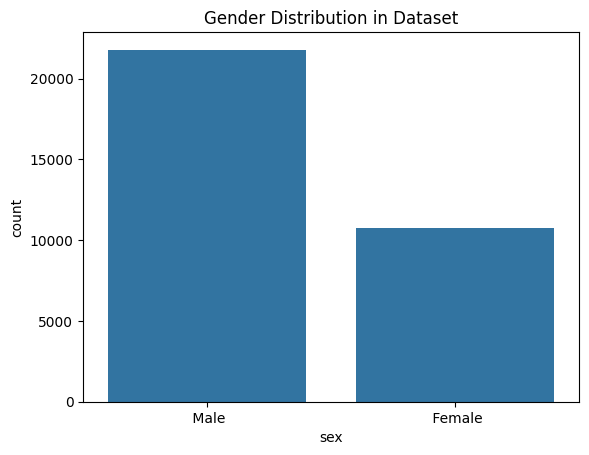

In [52]:
sns.countplot(data=train_df, x='sex')
plt.title("Gender Distribution in Dataset")
plt.show()

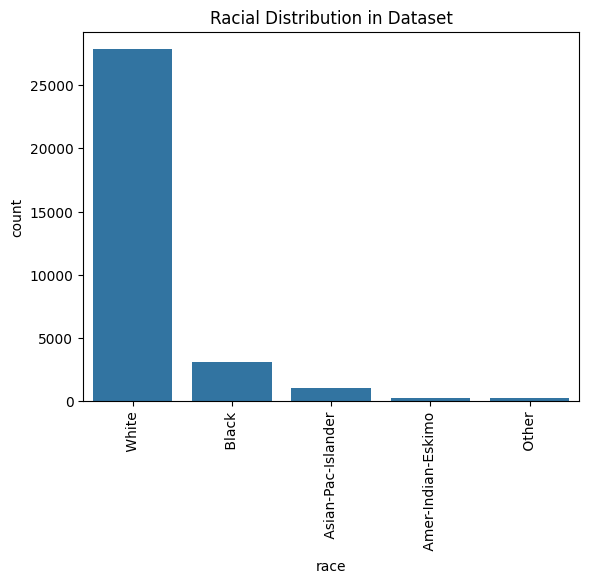

In [53]:
sns.countplot(data=train_df, x='race')
plt.xticks(rotation=90)
plt.title("Racial Distribution in Dataset")
plt.show()

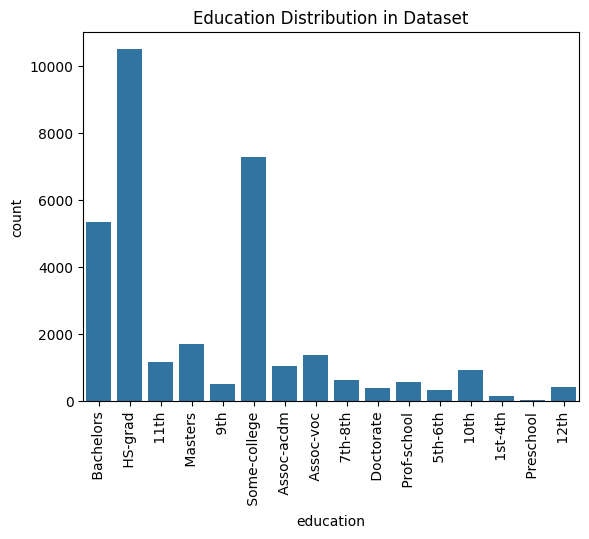

In [54]:
sns.countplot(data=train_df, x='education')
plt.xticks(rotation=90)
plt.title("Education Distribution in Dataset")
plt.show()

## Age vs Income

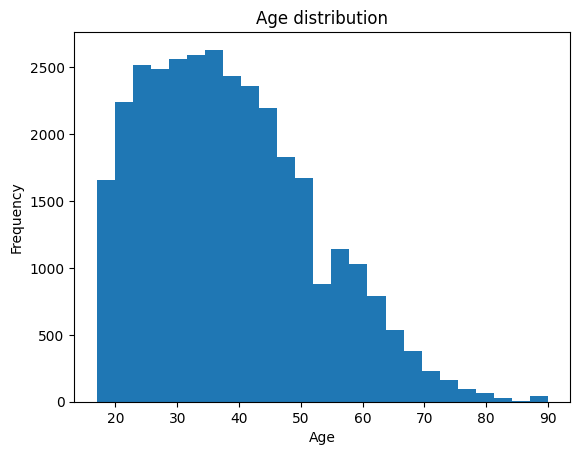

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Histogram of age
plt.hist(train_df['age'], bins=25)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age distribution')
plt.show()

## Sex vs Income

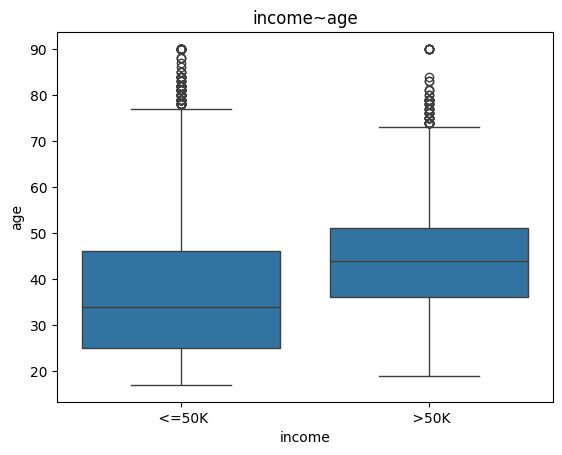

In [56]:
sns.boxplot(x='income', y='age', data=train_df)
plt.xlabel('income')
plt.ylabel('age')
plt.title('income~age')
# plt.xticks(rotation=90)
plt.show()


## Race and Age vs Income:

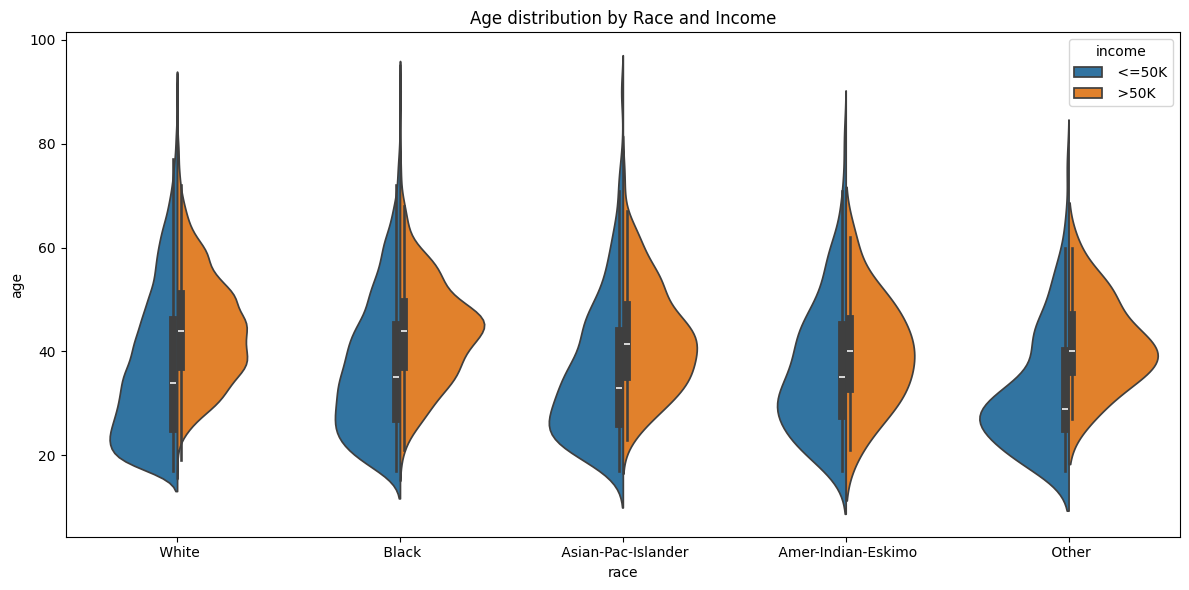

In [57]:
# A violin plot of Age distribution by race, and income
plt.figure(figsize=(12, 6))
sns.violinplot(data=train_df, x='race', y='age', hue='income', split=True)
plt.title('Age distribution by Race and Income')
plt.tight_layout()
plt.show()


## Random Forest Classification

In [58]:
# Encoding the target variable
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the combined set of labels from both train and test data
combined_labels = pd.concat([train_df['income'], test_df['income']], axis=0)
label_encoder.fit(combined_labels)

# Transform the income column in both train and test data
train_df['income'] = label_encoder.transform(train_df['income'])
test_df['income'] = label_encoder.transform(test_df['income'])

X = train_df.drop(columns=['income'])
y = train_df['income']
X = pd.get_dummies(X, drop_first=True)

# Using the entire dataset for training
X_train = X
y_train = y

X_test = test_df.drop(columns=['income'])
y_test = test_df['income']
X_test = pd.get_dummies(X_test, drop_first=True)

X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Training a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8527117498925127

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.72      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281



### Feature Importance - Random Forest

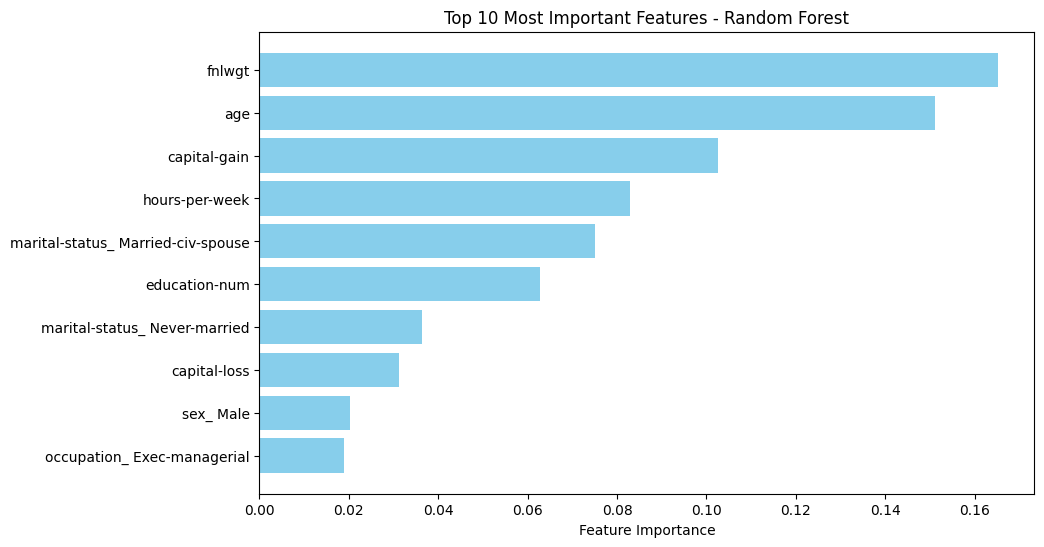

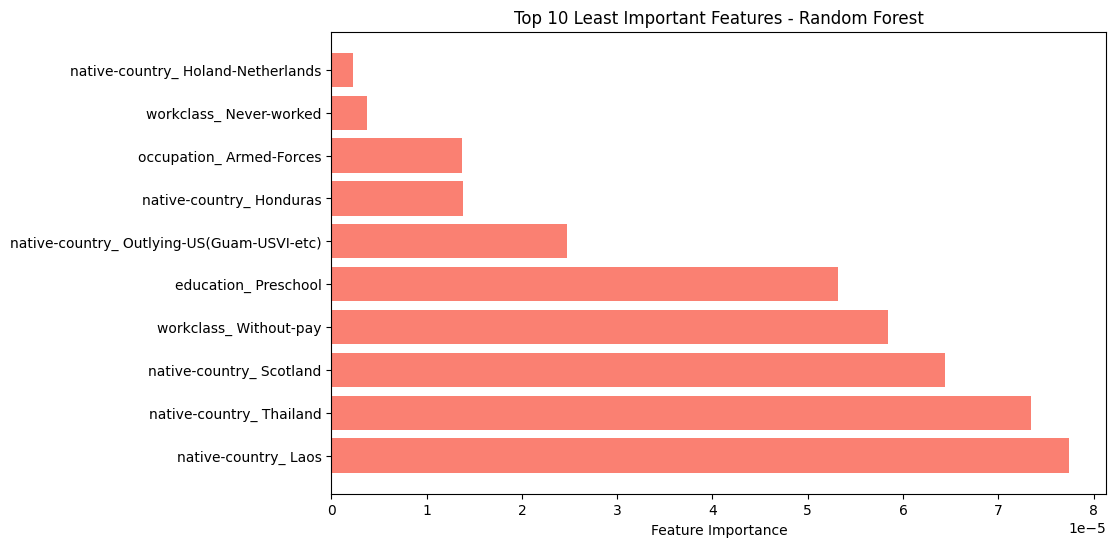

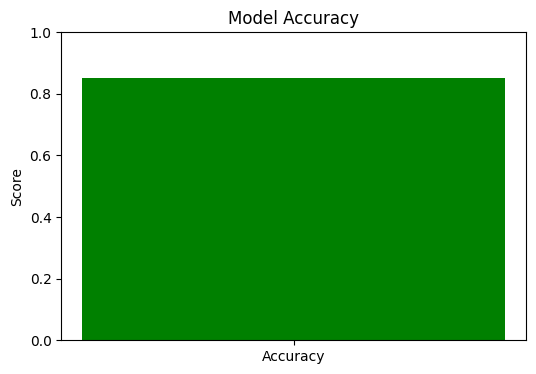

In [59]:
# Get feature importances from the classifier
feature_importances = clf.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot the most important features
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10][::-1], sorted_importances[:10][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features - Random Forest')
plt.show()

# Plot the least important features
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[-10:], sorted_importances[-10:], color='salmon')
plt.xlabel('Feature Importance')
plt.title('Top 10 Least Important Features - Random Forest')
plt.show()

# Plot accuracy
accuracy = accuracy_score(y_test, y_pred)
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='green')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Accuracy')
plt.show()

### Grid Search with Random Forest

In [60]:
# Defing the model pipeline
pipe = Pipeline([
    ("scalar", StandardScaler()),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Define parameters for hyperparameter tuning for grid search
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")



Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Cross-Validation Score: 0.8626


### Extreme Error Analysis

In [61]:
y_pred = grid_search.best_estimator_.predict(X_test)
errors = X_test[y_pred != y_test]
errors['predicted'] = y_pred[y_pred != y_test]
errors['actual'] = y_test[y_pred != y_test]
# Display the first 10 errors
pd.set_option('display.max_columns', None)
print(errors.head(10))

     age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
2     28  336951             12             0             0              40   
11    36  212465             13             0             0              40   
14    48  279724              9          3103             0              48   
45    28  242832             11             0             0              36   
71    46  175622             11             0             0              40   
87    55  160631              9             0             0              56   
98    59  272087              9             0             0              40   
112   29  337266             11             0             0              40   
119   43  179866             13             0             0              40   
128   27  115438              9             0             0              60   

     workclass_ Federal-gov  workclass_ Local-gov  workclass_ Never-worked  \
2                     False                  True   

In [62]:
X_test_grouped =  X_test.copy()
X_test_grouped['predicted'] = y_pred
X_test_grouped['actual'] = y_test

X_test_grouped = X_test_grouped.join(test_df[['sex', 'race', 'education', 'age']], how='left', rsuffix='_test')

# Group and count
misclassified_grouped = X_test_grouped[X_test_grouped['actual'] != X_test_grouped['predicted']]
group_counts = misclassified_grouped.groupby(['sex', 'race', 'education']).size().sort_values(ascending=False)

group_counts.head(10)

sex     race   education   
Male    White  HS-grad         531
               Some-college    376
               Bachelors       343
               Masters         118
               Assoc-voc       103
Female  White  Bachelors        90
               HS-grad          66
Male    White  Assoc-acdm       64
Female  White  Some-college     55
               Masters          49
dtype: int64

## Income, Marital Status, and Occupation in a bar graph

   Marital Status         Occupation  Average Income
0        Divorced                  ?        0.032432
1        Divorced       Adm-clerical        0.031746
2        Divorced       Craft-repair        0.096983
3        Divorced    Exec-managerial        0.236755
4        Divorced    Farming-fishing        0.078125
..            ...                ...             ...
91        Widowed     Prof-specialty        0.206522
92        Widowed    Protective-serv        0.111111
93        Widowed              Sales        0.190476
94        Widowed       Tech-support        0.105263
95        Widowed   Transport-moving        0.080000

[96 rows x 3 columns]


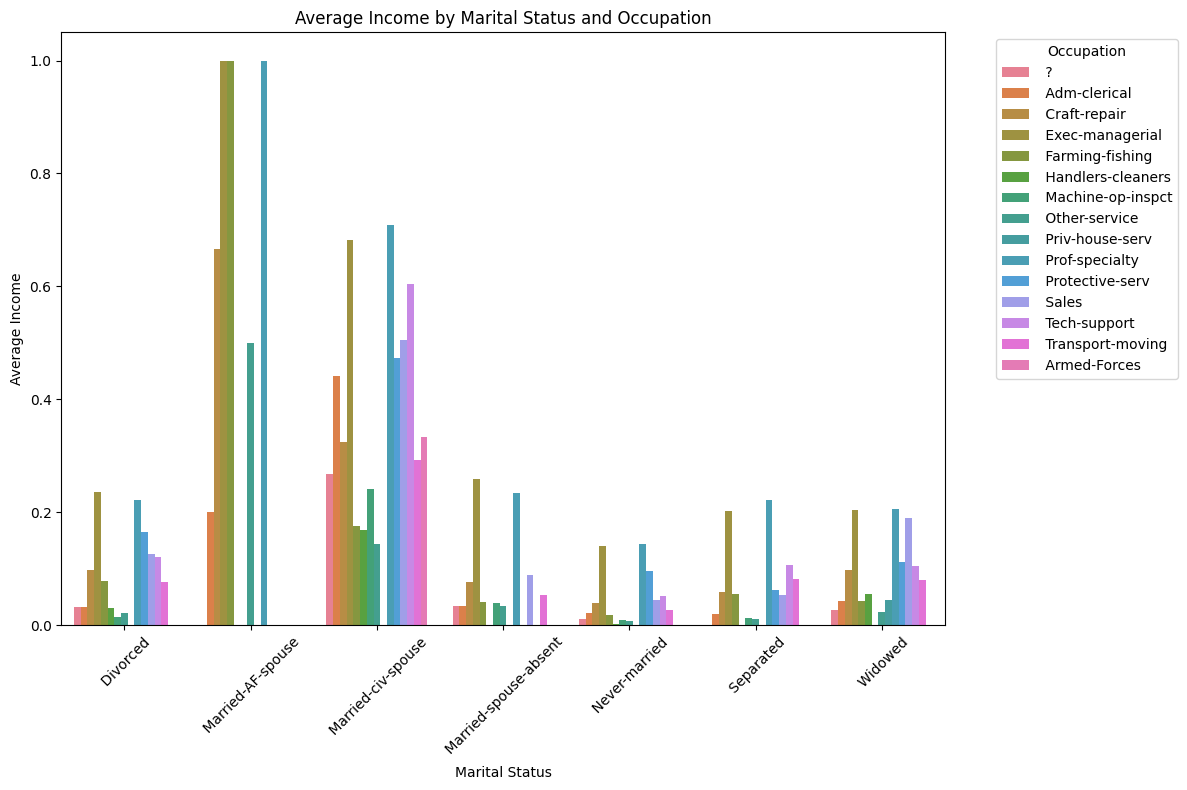

In [63]:
# Group by marital status and occupation, and calculate the average income
analysis = train_df.groupby(['marital-status', 'occupation'])['income'].mean().reset_index()

# Renaming the columns for clarity
analysis.columns = ['Marital Status', 'Occupation', 'Average Income']

print(analysis)

plt.figure(figsize=(12, 8))
sns.barplot(data=analysis, x='Marital Status', y='Average Income', hue='Occupation')
plt.xticks(rotation=45)
plt.title('Average Income by Marital Status and Occupation')
plt.ylabel('Average Income')
plt.xlabel('Marital Status')
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Permuted MLP Classifier and Feature Importance

MLP Test Accuracy: 0.8041
MLP Train Accuracy: 0.8021

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     12435
           1       0.78      0.59      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.77      0.79     16281
weighted avg       0.86      0.86      0.86     16281

Number of features: 100
Number of training samples: 32561
Number of test samples: 16281


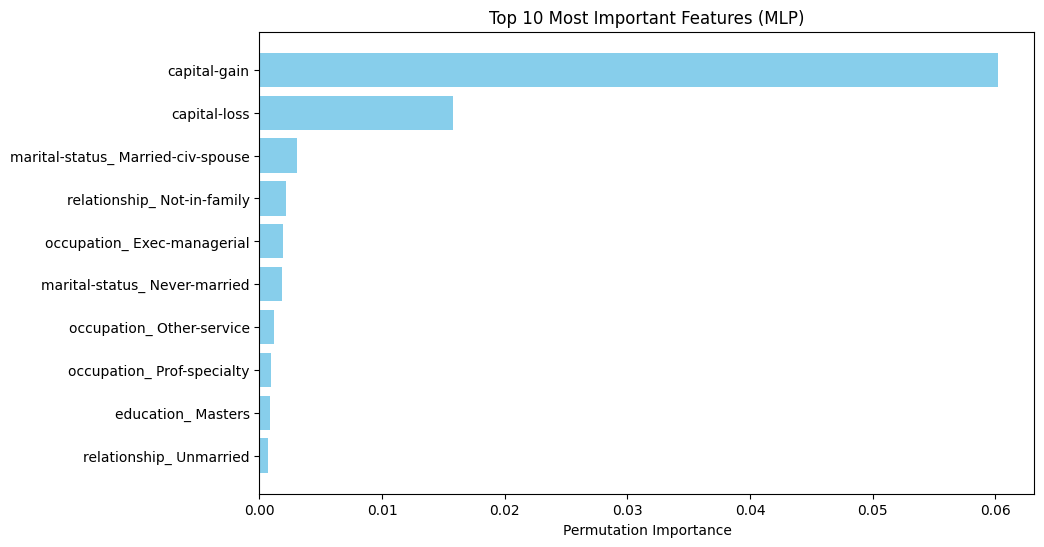

In [64]:
# Train an MLP classifier
mlp_clf = MLPClassifier(
    random_state=42,
    max_iter=1000, 
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    alpha=0.0001
)
mlp_clf.fit(X_train, y_train)

# Get feature importances using permutation importance
perm_importance = permutation_importance(mlp_clf, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
sorted_indices = np.argsort(perm_importance.importances_mean)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = perm_importance.importances_mean[sorted_indices]


mlp_train_accuracy = mlp_clf.score(X_train, y_train)

# Print accuracy comparison
print(f"MLP Test Accuracy: {accuracy_score(y_test, mlp_clf.predict(X_test)):.4f}")
print(f"MLP Train Accuracy: {mlp_train_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print(f"Number of features: {X_train.shape[1]}")
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")


plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10][::-1], sorted_importances[:10][::-1], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Top 10 Most Important Features (MLP)')
plt.show()

### Simple MLP Classifier with Feature Importance

Simpler MLP Test Accuracy: 0.8095
Simpler MLP Train Accuracy: 0.8076


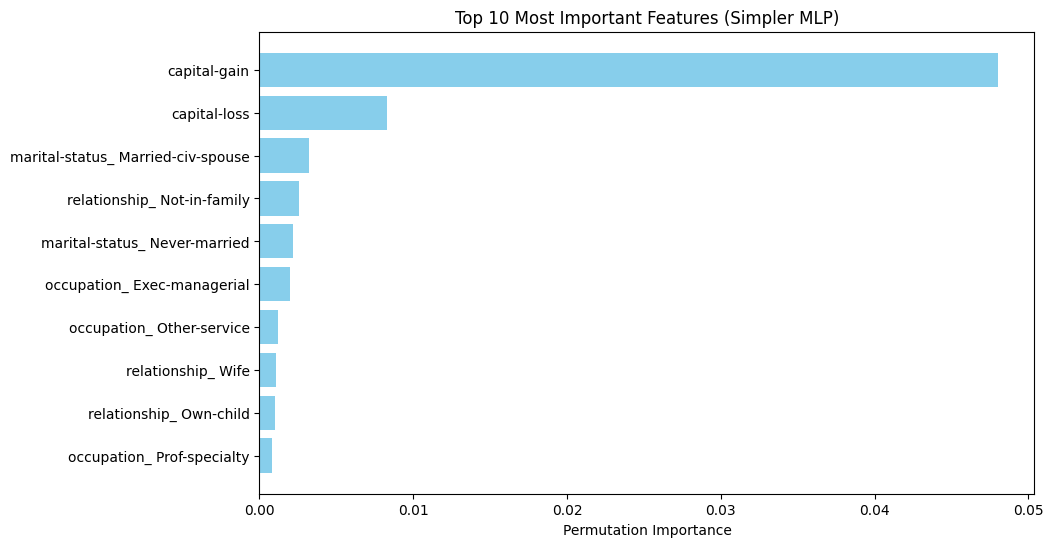

In [65]:
# Train a simpler MLP classifier
# Reduced iterations from 1000 to 500 as 1000 was too long
simple_mlp_clf = MLPClassifier(
    random_state=42,
    max_iter=500,
    hidden_layer_sizes=(50,),
    activation='relu',
    solver='adam',
    learning_rate='constant',
    alpha=0.01 
)
simple_mlp_clf.fit(X_train, y_train)

# Get feature importances using permutation importance
simple_perm_importance = permutation_importance(simple_mlp_clf, X_test, y_test, n_repeats=5, random_state=42)

simple_sorted_indices = np.argsort(simple_perm_importance.importances_mean)[::-1]
simple_sorted_features = X.columns[simple_sorted_indices]
simple_sorted_importances = simple_perm_importance.importances_mean[simple_sorted_indices]

# Evaluate the simpler MLP classifier
simple_mlp_train_accuracy = simple_mlp_clf.score(X_train, y_train)
simple_mlp_test_accuracy = accuracy_score(y_test, simple_mlp_clf.predict(X_test))

print(f"Simpler MLP Test Accuracy: {simple_mlp_test_accuracy:.4f}")
print(f"Simpler MLP Train Accuracy: {simple_mlp_train_accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(simple_sorted_features[:10][::-1], simple_sorted_importances[:10][::-1], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Top 10 Most Important Features (Simpler MLP)')
plt.show()

### Grid Search and K-fold for Permutation MLP

In [66]:
# Define the model pipeline
pipe = Pipeline([
    ("scalar", StandardScaler()),
    ("classifier", MLPClassifier(max_iter=500 ,random_state=42))
])

# Define parameters for hyperparameter tuning for grid search
param_grid = {
    "classifier__hidden_layer_sizes": [(50,), (100, 50)],
    "classifier__activation": ["relu", "tanh"],
    "classifier__alpha": [0.0001, 0.01]
}

# Perform grid search with cross-validation and print results
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

Best Parameters: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50,)}
Best Cross-Validation Score: 0.8394


### Extreme Error Analysis

In [67]:
y_pred = grid_search.best_estimator_.predict(X_test)
errors = X_test[y_pred != y_test]
errors['predicted'] = y_pred[y_pred != y_test]
errors['actual'] = y_test[y_pred != y_test]
# Display the first 10 errors
print(errors.head(10))

    age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
2    28  336951             12             0             0              40   
10   65  184454              9          6418             0              40   
11   36  212465             13             0             0              40   
17   43  128354              9             0             0              30   
19   40   85019             16             0             0              45   
36   36  403681             13             0             0              40   
47   54  186272             10          3908             0              50   
71   46  175622             11             0             0              40   
87   55  160631              9             0             0              56   
98   59  272087              9             0             0              40   

    workclass_ Federal-gov  workclass_ Local-gov  workclass_ Never-worked  \
2                    False                  True                

In [68]:
X_test_grouped =  X_test.copy()
X_test_grouped['predicted'] = y_pred
X_test_grouped['actual'] = y_test

X_test_grouped = X_test_grouped.join(test_df[['sex', 'race', 'education', 'age']], how='left', rsuffix='_test')

# Group and count
misclassified_grouped = X_test_grouped[X_test_grouped['actual'] != X_test_grouped['predicted']]
group_counts = misclassified_grouped.groupby(['sex', 'race', 'education']).size().sort_values(ascending=False)

group_counts.head(10)

sex     race   education   
Male    White  HS-grad         610
               Some-college    441
               Bachelors       392
               Masters         139
               Assoc-voc       112
Female  White  Bachelors       105
               Some-college     79
               HS-grad          77
Male    White  Assoc-acdm       71
Female  White  Masters          56
dtype: int64

## Gradient Boosting Classifier

In [69]:
# Train a Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
# Focus only on education, marital status, native country, and relationship as features
selected_features = [col for col in X.columns if any(prefix in col for prefix in ['marital-status_', 'relationship_', 'education_', 'native-country_'])]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the Gradient Boosting Classifier with the selected features
gb_clf.fit(X_train_selected, y_train)

# Make predictions
y_pred_gb = gb_clf.predict(X_test_selected)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Classifier Accuracy:", accuracy_gb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

Gradient Boosting Classifier Accuracy: 0.8227381610466188

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89     12435
           1       0.71      0.42      0.53      3846

    accuracy                           0.82     16281
   macro avg       0.78      0.68      0.71     16281
weighted avg       0.81      0.82      0.81     16281



### Feature Importance

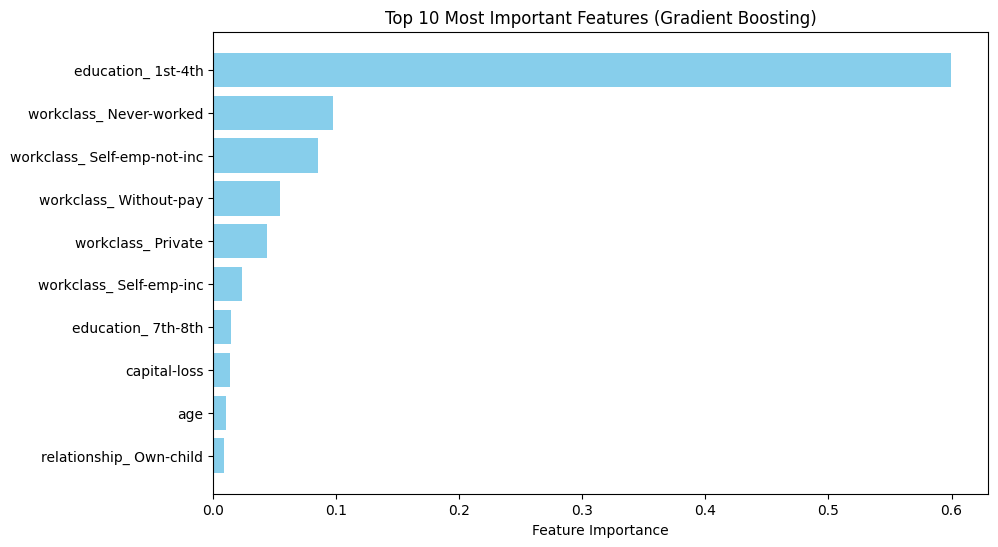

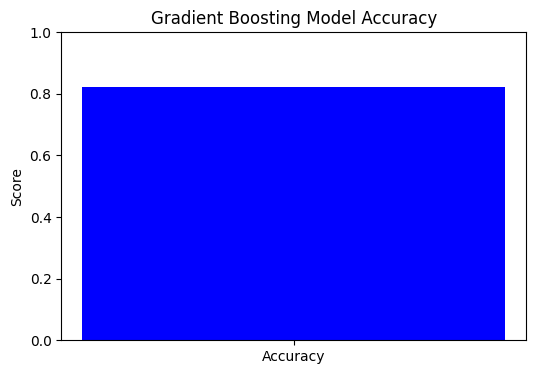

In [70]:
# Get feature importances
feature_importances_gb = gb_clf.feature_importances_
sorted_indices_gb = feature_importances_gb.argsort()[::-1]
sorted_features_gb = X.columns[sorted_indices_gb]
sorted_importances_gb = feature_importances_gb[sorted_indices_gb]

# Plot the most important features
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_gb[:10][::-1], sorted_importances_gb[:10][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features (Gradient Boosting)')
plt.show()

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy_gb], color='blue')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Gradient Boosting Model Accuracy')
plt.show()


### Grid Search and K-fold for Gradient Boosting Model

In [71]:
# Define the model pipeline
pipe = Pipeline([
    ("scalar", StandardScaler()),
    ("classifier", GradientBoostingClassifier(random_state=42))
])

# Define parameters for hyperparameter tuning for grid search
param_grid = {
    "classifier__n_estimators": [300, 500, 1000],
    "classifier__learning_rate": [0.1, 0.01],
    "classifier__max_depth": [3, 5]
}

# Perform grid search with cross-validation and print results
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 500}
Best Cross-Validation Score: 0.8724


### Extreme Error Analysis

In [72]:
y_pred = grid_search.best_estimator_.predict(X_test)
errors = X_test[y_pred != y_test]
errors['predicted'] = y_pred[y_pred != y_test]
errors['actual'] = y_test[y_pred != y_test]
# Display the first 10 errors
pd.set_option('display.max_columns', None)
print(errors.head(10))

     age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
2     28  336951             12             0             0              40   
11    36  212465             13             0             0              40   
45    28  242832             11             0             0              36   
71    46  175622             11             0             0              40   
98    59  272087              9             0             0              40   
106   41  201520              9             0             0              40   
112   29  337266             11             0             0              40   
119   43  179866             13             0             0              40   
128   27  115438              9             0             0              60   
130   41  428420             10             0             0              40   

     workclass_ Federal-gov  workclass_ Local-gov  workclass_ Never-worked  \
2                     False                  True   

In [73]:
X_test_grouped =  X_test.copy()
X_test_grouped['predicted'] = y_pred
X_test_grouped['actual'] = y_test

X_test_grouped = X_test_grouped.join(test_df[['sex', 'race', 'education', 'age']], how='left', rsuffix='_test')

# Group and count
misclassified_grouped = X_test_grouped[X_test_grouped['actual'] != X_test_grouped['predicted']]
group_counts = misclassified_grouped.groupby(['sex', 'race', 'education']).size().sort_values(ascending=False)

group_counts.head(10)

sex     race   education   
Male    White  HS-grad         493
               Some-college    327
               Bachelors       317
               Masters         106
               Assoc-voc        90
Female  White  Bachelors        79
               Some-college     58
               HS-grad          57
Male    White  Assoc-acdm       53
Female  White  Masters          43
dtype: int64

## Logistic Regression with Feature Importance

In [74]:
X = pd.get_dummies(X_train, drop_first=True)
y = y_train

# Scale the numeric features (age)
scaler = StandardScaler()
X['age'] = scaler.fit_transform(X[['age']])

# Fit logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Display the coefficients to which have the most impact on the model
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, log_reg.predict(X_test)))
print("\nClassification Report:\n", classification_report(y_test, log_reg.predict(X_test)))

                               Feature  Coefficient
30  marital-status_ Married-civ-spouse     0.978821
38         occupation_ Exec-managerial     0.970701
44          occupation_ Prof-specialty     0.647704
25                  education_ Masters     0.527777
22                education_ Bachelors     0.458447
..                                 ...          ...
52             relationship_ Unmarried    -0.649184
42           occupation_ Other-service    -0.790860
24                  education_ HS-grad    -0.857096
51             relationship_ Own-child    -1.127789
32       marital-status_ Never-married    -1.464103

[100 rows x 2 columns]

Logistic Regression Accuracy: 0.847613782937166

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     12435
           1       0.73      0.57      0.64      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.75      0.77     16281
weight

### Feature Importance for Logistic Regression

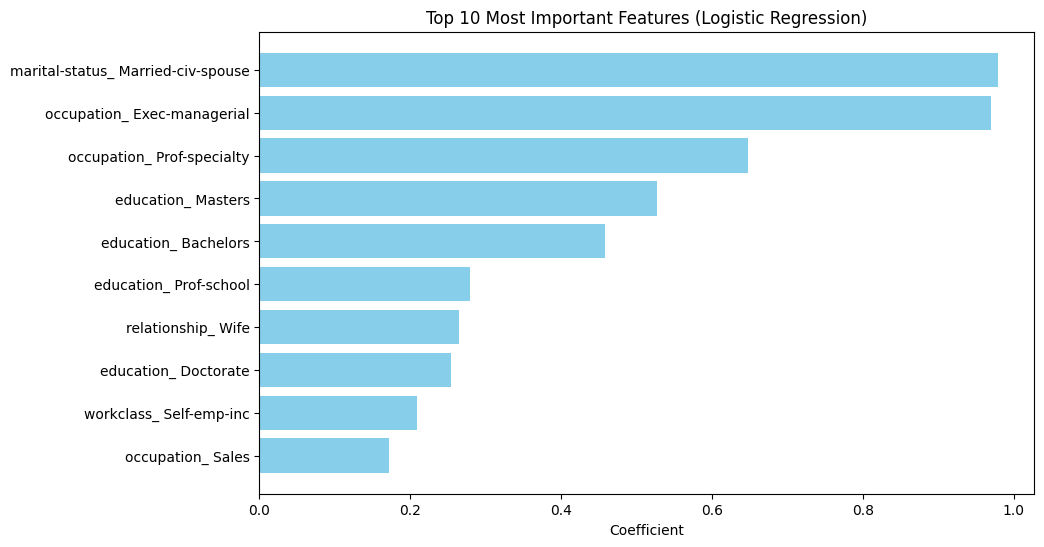

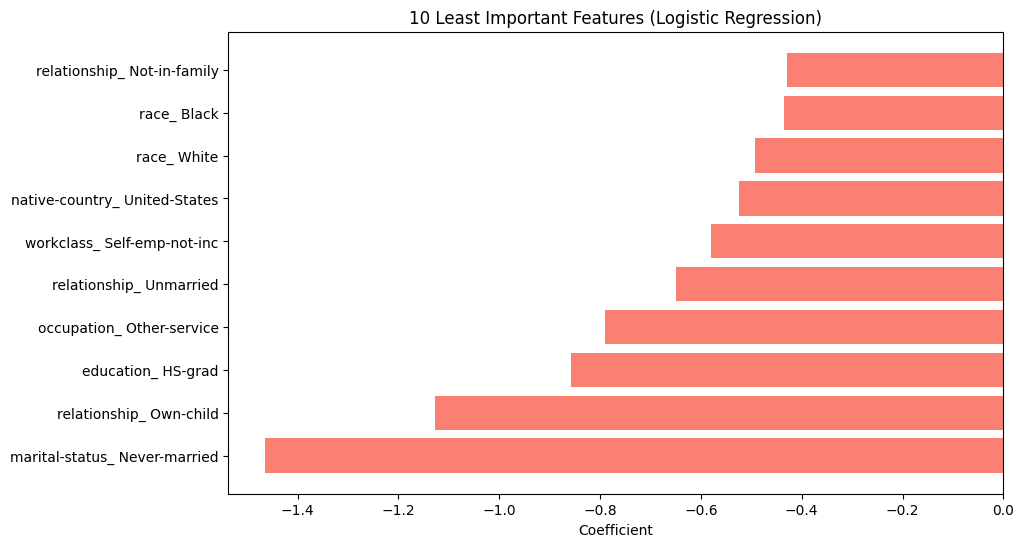

In [75]:
# Plot the most important features
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:10][::-1], coef_df['Coefficient'][:10][::-1], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Top 10 Most Important Features (Logistic Regression)')
plt.show()

# Plot the least important features
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][-10:][::-1], coef_df['Coefficient'][-10:][::-1], color='salmon')
plt.xlabel('Coefficient')
plt.title('10 Least Important Features (Logistic Regression)')
plt.show()

### Adding Grid Search to Logistic Regression

In [76]:
# Define the model pipeline
pipe = Pipeline([
    ("scalar", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=500))
])

# Define parameters for hyperparameter tuning for grid search
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear"],
}

# Perform grid search with cross-validation and print results
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Cross-Validation Score: 0.8523


### Extreme Error Analysis

In [77]:
y_pred = grid_search.best_estimator_.predict(X_test)
errors = X_test[y_pred != y_test]
errors['predicted'] = y_pred[y_pred != y_test]
errors['actual'] = y_test[y_pred != y_test]
# Display the first 10 errors
pd.set_option('display.max_columns', None)
print(errors.head(10))

    age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0    25  226802              7             0             0              40   
1    38   89814              9             0             0              50   
4    18  103497             10             0             0              30   
5    34  198693              6             0             0              30   
6    29  227026              9             0             0              40   
8    24  369667             10             0             0              40   
9    55  104996              4             0             0              10   
11   36  212465             13             0             0              40   
12   26   82091              9             0             0              39   
13   58  299831              9             0             0              35   

    workclass_ Federal-gov  workclass_ Local-gov  workclass_ Never-worked  \
0                    False                 False                

### Analyze categories that are missclassified the most

In [78]:
X_test_grouped =  X_test.copy()
X_test_grouped['predicted'] = y_pred
X_test_grouped['actual'] = y_test

X_test_grouped = X_test_grouped.join(test_df[['sex', 'race', 'education', 'age']], how='left', rsuffix='_test')

# Group and count
misclassified_grouped = X_test_grouped[X_test_grouped['actual'] != X_test_grouped['predicted']]
group_counts = misclassified_grouped.groupby(['sex', 'race', 'education']).size().sort_values(ascending=False)

group_counts.head(10)

sex     race   education   
Male    White  HS-grad         2463
               Some-college    1432
Female  White  HS-grad         1235
               Some-college    1029
Male    White  Bachelors        799
Female  White  Bachelors        563
Male    Black  HS-grad          276
Female  Black  HS-grad          274
Male    White  Assoc-voc        271
               11th             261
dtype: int64

## Analyze and compare various configurations for each model

In [79]:
def model_evaluation(modelConfigs, X_train, y_train, X_test, y_test):
    results = []
    for name, model in modelConfigs.items():
            # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        results.append((name, accuracy))
    return results


# Define models to evaluate
modelConfigs = {
    "LogReg_l2_C1": LogisticRegression(C=1.0, max_iter=500),
    "LogReg_l2_C0.01": LogisticRegression(C=0.01, max_iter=500),
    "RF_100": RandomForestClassifier(n_estimators=100),
    "RF_300": RandomForestClassifier(n_estimators=300),
    "GB_100": GradientBoostingClassifier(n_estimators=100),
    "GB_300": GradientBoostingClassifier(n_estimators=300),
    "MLP_50": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500),
    "MLP_100_50": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500),
    "MLP_relu": MLPClassifier(hidden_layer_sizes=(50,), activation="relu", max_iter=500),
    "MLP_tanh": MLPClassifier(hidden_layer_sizes=(50,), activation="tanh", max_iter=500)
}

# Evaluate models
results = model_evaluation(modelConfigs, X_train, y_train, X_test, y_test)
# Print results
for name, accuracy in results:
    print(f"| {name}: | {accuracy:.4f}")


| LogReg_l2_C1: | 0.8470
| LogReg_l2_C0.01: | 0.8450
| RF_100: | 0.8544
| RF_300: | 0.8518
| GB_100: | 0.8709
| GB_300: | 0.8766
| MLP_50: | 0.7993
| MLP_100_50: | 0.7712
| MLP_relu: | 0.7990
| MLP_tanh: | 0.7678


## Analysis of features with most impact on the income
| **Feature**                          | **Impact on Income** |
|--------------------------------------|----------------------|
| marital-status_Married-civ-spouse  | Positive           |
| education                          | Positive           |
| age                                | Slight Positive    |
| hours-per-week                     | Positive           |
| capital-gain                       | Positive           |
| occupation_Exec-managerial         | Positive           |
| sex_Male                           | Positive (Bias)    |

Summary:
Individuals with investments tend to report an income > 50k. Individuals with higher education, speciality occupations, in managerial roles, and those that work more hours show a positive correlation with higher income earnings. There is a positive correlation between sex and income indicating a bias favoring men. There is also a correlation between married individuals and higher income, perhaps due to having more financial stability and dual incomes. There is a slight correlation between age and income, indicating older inviduals earn more as they have more experience. There is also a slight correlation between US born and white individuals.

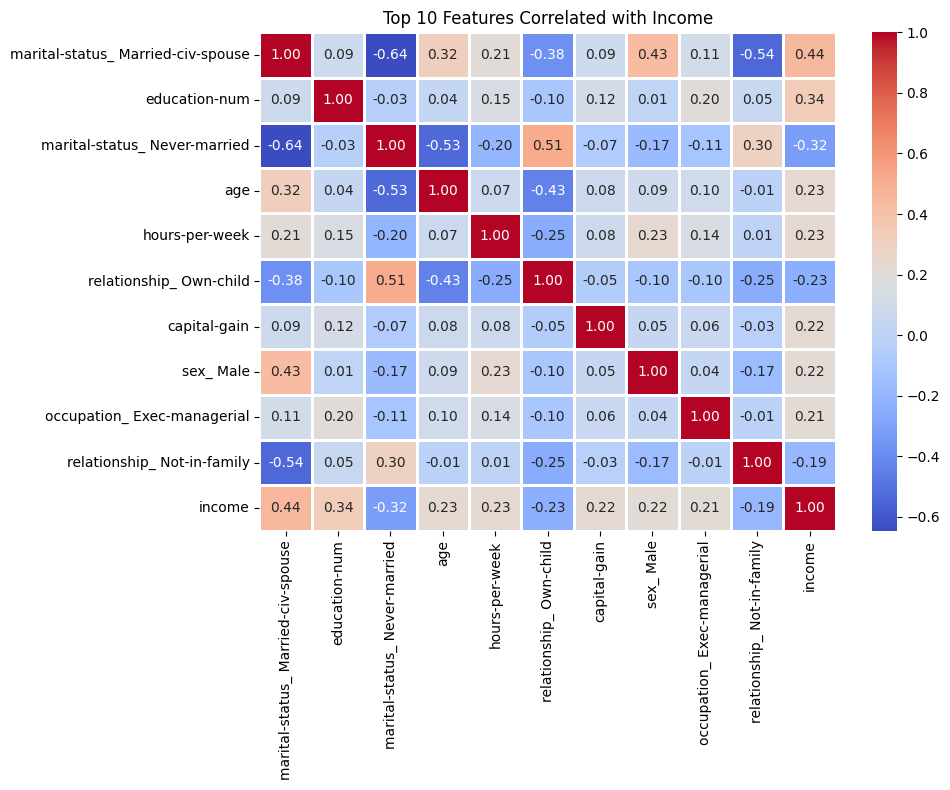

In [93]:
train_df_encoded = pd.get_dummies(train_df.copy(), drop_first=True)

corr_matrix = train_df_encoded.corr()

# Get top 10 features correlated with the target variable
target_col = 'income'
top_corr = corr_matrix[target_col].abs().sort_values(ascending=False)[1:11]

# Step 5: Get submatrix for top features + target
top_features = top_corr.index.tolist() + [target_col]
top_corr_matrix = train_df_encoded[top_features].corr()

# Step 6: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
plt.title("Top 10 Features Correlated with Income")
plt.tight_layout()
plt.show()